<h1> HOW TO: </h1>

1. Edit the configs list in Cell 3 (CONFIG DEFINITIONS) with all experiments you want to try
2. Run Cell 2 (RESULT STORAGE) to initialize results storage
3. Run Cell 4 (TRAINING FUNCTION) to define the training function
4. Run Cell 5 (MAIN EXECUTION LOOP) to start training 
5. When done, run Cells 6-8 to analyze and save results

<h2> Imports

In [1]:
import sys
sys.path.append("../src")
from precomputed_dataset import precomputedDataset
from modules import MPNNLayer, MPNNTokenizer, SelfAttentionEncoder, PredictionHead
from model import MPNNTransformerModel

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader as PyGDataLoader

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from datetime import datetime
import time
import json

<h2> Result Storage & Utility </h2>

In [2]:
# --- Results for all configurations ---
all_results = []

# --- Utility function to check gradient flow ---
def check_gradients(model):
    """Check if gradients are flowing properly"""
    total_norm = 0.0
    param_count = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
            param_count += 1
    total_norm = total_norm ** 0.5
    return total_norm, param_count

<h2> Config definitions

In [4]:
# --- define each configuration as a dictionary ---
configs = [
    {
        'name': 'mpnn_layer_1', #Find MPNN layer count then
        'num_epochs': 1000,
        # --- Architecture ---
        'mpnn_hidden_dim': 128,
        'mpnn_num_layers': 1, # Set this 
        'mp_layer_norm': False,
        'token_dim': 128,
        'attn_num_heads': 4, 
        'attn_num_layers': 4, # Set this later
        'head_mlp_hidden_dim': 256,
        'mpnn_dropout': 0.1,
        'attn_dropout': 0.1,
        'head_dropout': 0.1,
        'pooling_strategy': 'cls_token',
        # --- Hyperparameters ---
        'lr': 1e-4,
        'weight_decay': 0.0,
        'batch_size': 32,
        # --- Scheduler params --- 
        'scheduler': False,
        'mode': 'min',
        'factor': 0.5,
        'patience': 10,
        'threshold': 1e-5, 
        'threshold_mode': "rel",
        'cooldown': 5,
        'min_lr': 1e-7,
    },
    {
        'name': 'mpnn_layer_2', 
        'num_epochs': 1000,
        # --- Architecture ---
        'mpnn_hidden_dim': 128,
        'mpnn_num_layers': 2, # Set this 
        'mp_layer_norm': False,
        'token_dim': 128,
        'attn_num_heads': 4, 
        'attn_num_layers': 4, # Set this later 
        'head_mlp_hidden_dim': 256,
        'mpnn_dropout': 0.1,
        'attn_dropout': 0.1,
        'head_dropout': 0.1,
        'pooling_strategy': 'cls_token',
        # --- Hyperparameters ---
        'lr': 1e-4,
        'weight_decay': 0.0,
        'batch_size': 32,
        # --- Scheduler params --- 
        'scheduler': False,
        'mode': 'min',
        'factor': 0.5,
        'patience': 10,
        'threshold': 1e-5, 
        'threshold_mode': "rel",
        'cooldown': 5,
        'min_lr': 1e-7,
    },
    {
        'name': 'mpnn_layer_3', #Try to set learning rates so it converges
        'num_epochs': 1000,
        # --- Architecture ---
        'mpnn_hidden_dim': 128,
        'mpnn_num_layers': 3, # Set this 
        'mp_layer_norm': False,
        'token_dim': 128,
        'attn_num_heads': 4, 
        'attn_num_layers': 4, # Set this later 
        'head_mlp_hidden_dim': 256,
        'mpnn_dropout': 0.1,
        'attn_dropout': 0.1,
        'head_dropout': 0.1,
        'pooling_strategy': 'cls_token',
        # --- Hyperparameters ---
        'lr': 1e-4,
        'weight_decay': 0.0,
        'batch_size': 32,
        # --- Scheduler params --- 
        'scheduler': False,
        'mode': 'min',
        'factor': 0.5,
        'patience': 10,
        'threshold': 1e-5, 
        'threshold_mode': "rel",
        'cooldown': 5,
        'min_lr': 1e-7,
    },
    
]

<h2> Training Function

In [ ]:
def train_single_config(config, device, h5_path, test_path, seed=0):
    """
    Train a model with given configuration and return results
    
    Returns:
        dict with training metrics and test performance
    """
    
    # Set seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    print(f"\n{'='*60}")
    print(f"TRAINING CONFIG: {config['name']}")
    print(f"{'='*60}\n")
    
    # --- Dataset setup ---
    ds = precomputedDataset(h5_path)
    loader = PyGDataLoader(
        ds, 
        batch_size=config['batch_size'], 
        shuffle=True,  
        num_workers=4, 
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_ds = precomputedDataset(test_path)
    
    # --- Model setup ---
    sample0 = ds[0]
    node_in_dim = sample0.x.shape[-1]
    edge_in_dim = sample0.edge_attr.shape[-1]
    
    model = MPNNTransformerModel(
        node_in_dim=node_in_dim,
        edge_in_dim=edge_in_dim,
        num_output_sources=1,
        mpnn_hidden_dim=config['mpnn_hidden_dim'],
        mpnn_num_layers=config['mpnn_num_layers'],
        mp_layer_norm=config['mp_layer_norm'],
        token_dim=config['token_dim'],
        attn_num_heads=config['attn_num_heads'],
        attn_num_layers=config['attn_num_layers'],
        head_mlp_hidden_dim=config['head_mlp_hidden_dim'],
        mpnn_dropout=config['mpnn_dropout'],
        attn_dropout=config['attn_dropout'],
        head_dropout=config['head_dropout'],
        pooling_strategy=config['pooling_strategy']
    ).to(device)
    
    # --- Optimizer and Scheduler ---
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay'],
        betas=(0.9, 0.999),
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode=config['mode'],
        factor=config['factor'],          
        patience=config['patience'],       
        threshold=config['threshold'],    
        threshold_mode=config['threshold_mode'],
        cooldown=config['cooldown'],        
        min_lr=config['min_lr'],
    )
    
    # --- General Tracking ---
    loss_history = []
    pred_std_history = []
    grad_norm_history = []

    # --- Early stopping tracking and settings ---
    best_test_loss = float('inf')
    corresponding_best_train_loss = float('inf') #Train loss that corresponds to best test loss
    patience_counter = 0
    patience = 50 # Set here 
    min_delta = 1e-5 # Set here
    test_loss_history = []
    

    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)

    # --- Training loop ---
    for epoch in range(1, config['num_epochs'] + 1):
        model.train()
        epoch_loss = 0.0
        epoch_preds = []
        
        for batch_idx, data in enumerate(loader):
            data = data.to(device)
            pred = model.forward_from_data(data)  
            target = data.y  

            assert pred.shape == target.shape
            
            loss = F.mse_loss(pred, target)
            
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_preds.append(pred.detach().cpu().numpy())
        
        # --- Epoch statistics ---
        avg_loss = epoch_loss / len(loader)
        loss_history.append(avg_loss)

        if config['scheduler'] == True:
            scheduler.step(avg_loss)

        grad_norm, _ = check_gradients(model)
        grad_norm_history.append(grad_norm)
        
        all_preds = np.concatenate(epoch_preds, axis=0)
        pred_std = all_preds.std(axis=0).mean()
        pred_std_history.append(pred_std)
        

        
        # --- Validate for early stopping ---
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data in test_ds:
                data = data.to(device)
                pred = model.forward_from_data(data)
                target = data.y.squeeze(0)
                test_loss += F.mse_loss(pred, target).item()
        
        avg_test_loss = test_loss / len(test_ds)
        test_loss_history.append(avg_test_loss)
        
        # --- Early stopping ---
        if avg_test_loss < best_test_loss - min_delta:
            best_test_loss = avg_test_loss
            corresponding_best_train_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch} (test_loss={avg_test_loss:.6f})")
                break

        # Logging
        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch:4d} | Train Loss: {avg_loss:.6f} | Test Loss: {avg_test_loss:.6f} | Best Test: {best_test_loss:.6f} | Patience: {patience_counter}/{patience} | LR: {optimizer.param_groups[0]['lr']:.2e} | Pred_std: {pred_std:.4f}")
                 #Grad_norm: {grad_norm:.4f} |

        ###############
        
        # Check for collapse
        if pred_std < 0.004:
            print(f"  WARNING: Predictions collapsed at epoch {epoch}!")
            break
        
        # Early stopping
        if avg_loss < 5e-5:
            print(f"  Converged at epoch {epoch}")
            break
    
    final_train_loss = loss_history[-1]
    
    # --- Evaluation ---
    print(f"\nEvaluating on test set...")
    #test_ds was already loaded for early stopping
    model.eval()
    
    test_loss = 0.0
    with torch.no_grad():
        for data in test_ds:
            data = data.to(device)
            pred = model.forward_from_data(data)
            target = data.y.squeeze(0)
            test_loss += F.mse_loss(pred, target).item()
    
    avg_test_loss = test_loss / len(test_ds)
    
    print(f"Final train loss: {final_train_loss:.6f}")
    print(f"Test loss: {avg_test_loss:.6f}")
    print(f"Generalization gap: {avg_test_loss - final_train_loss:.6f}")
    
    # Return results
    results = {
        'config_name': config['name'],
        'final_train_loss': final_train_loss,
        'final_test_loss': avg_test_loss,
        'final_generalization_gap': avg_test_loss - final_train_loss,
        'best_test_loss': best_test_loss,
        'best_corresponding_train_loss': corresponding_best_train_loss,
        'best_generalization_gap': best_test_loss - corresponding_best_train_loss,
        'epochs_trained': len(loss_history),
        'loss_history': loss_history,
        'pred_std_history': pred_std_history,
        'config': config.copy()
    }
    
    # Clean up
    del model, optimizer, loader, ds, test_ds
    torch.cuda.empty_cache()
    
    return results

<h2> Main Execution Loop

In [7]:
# --- seed, device and data path setup ---
SEED = 0
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
h5_path = "../../simulated_data/b_train_10k.h5"
test_path = "../../simulated_data/b_test_1k.h5"
print(f"Using device: {device}")
print(f"Total configs to run: {len(configs)}\n")

# --- Run all configs ---
start_time = time.time()

for idx, config in enumerate(configs):
    print(f"\n{'#'*60}")
    print(f"# Running config {idx+1}/{len(configs)}: {config['name']}")
    print(f"{'#'*60}")
    
    config_start = time.time()
    
    # --- Train and evaluate the model for this config ---
    try:
        results = train_single_config(
            config=config,
            device=device,
            h5_path=h5_path,
            test_path=test_path,
            seed=SEED
        )
        
        # --- Add timestamp and runtime to results ---
        results['timestamp'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        results['runtime_seconds'] = time.time() - config_start
        
        all_results.append(results)
        
        print(f"\n✓ Config '{config['name']}' completed in {results['runtime_seconds']:.1f}s")
        
    # --- Still record the failed configs ---
    except Exception as e:
        print(f"\n✗ Config '{config['name']}' FAILED with error:")
        print(f"  {type(e).__name__}: {e}")
        
        all_results.append({
            'config_name': config['name'],
            'status': 'FAILED',
            'error': str(e),
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'config': config.copy()
        })
        
        # --- Continue with next config instead of crashing ---
        continue

total_time = time.time() - start_time
print(f"\n{'='*60}")
print(f"ALL CONFIGS COMPLETED")
print(f"Total time: {total_time/60:.1f} minutes")
print(f"{'='*60}\n")

Using device: cuda:2
Total configs to run: 3


############################################################
# Running config 1/3: mpnn_layer_1
############################################################

TRAINING CONFIG: mpnn_layer_1



/mnt/data/zaid/projects/geometry-aware-ssl/training/../src/modules.py:130: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer_encoder = nn.TransformerEncoder(



STARTING TRAINING
Epoch    1 | Train Loss: 0.024061 | Test Loss: 0.012239 | Best Test: 0.012239 | Patience: 0/50 | LR: 1.00e-04 | Pred_std: 0.0680
Epoch    2 | Train Loss: 0.013770 | Test Loss: 0.012046 | Best Test: 0.012046 | Patience: 0/50 | LR: 1.00e-04 | Pred_std: 0.1204
Epoch    3 | Train Loss: 0.012457 | Test Loss: 0.011563 | Best Test: 0.011563 | Patience: 0/50 | LR: 1.00e-04 | Pred_std: 0.1250
Epoch    4 | Train Loss: 0.011884 | Test Loss: 0.013499 | Best Test: 0.011563 | Patience: 1/50 | LR: 1.00e-04 | Pred_std: 0.1265
Epoch    5 | Train Loss: 0.011809 | Test Loss: 0.011071 | Best Test: 0.011071 | Patience: 0/50 | LR: 1.00e-04 | Pred_std: 0.1272
Epoch    6 | Train Loss: 0.011230 | Test Loss: 0.011443 | Best Test: 0.011071 | Patience: 1/50 | LR: 1.00e-04 | Pred_std: 0.1288
Epoch    7 | Train Loss: 0.011163 | Test Loss: 0.010945 | Best Test: 0.010945 | Patience: 0/50 | LR: 1.00e-04 | Pred_std: 0.1296
Epoch    8 | Train Loss: 0.010920 | Test Loss: 0.010733 | Best Test: 0.010733 

<h2> Results Analysis and Visualization

In [8]:
# --- Convert to DataFrame for easy analysis and summary ---
results_df = pd.DataFrame([
    {
        'Config': r['config_name'],
        'Train Loss': r.get('final_train_loss', np.nan),
        'Test Loss': r.get('test_loss', np.nan),
        'Gen Gap': r.get('generalization_gap', np.nan),
        'Epochs': r.get('epochs_trained', np.nan),
        'Runtime (min)': r.get('runtime_seconds', np.nan) / 60,
        'Status': r.get('status', 'SUCCESS')
    }
    for r in all_results
])

# --- Sort by test loss (best first) ---
results_df = results_df.sort_values('Test Loss')

print("RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# --- Find best config that succeeded ---
if len(results_df[results_df['Status'] == 'SUCCESS']) > 0:
    best_idx = results_df[results_df['Status'] == 'SUCCESS']['Test Loss'].idxmin()
    best_config = results_df.loc[best_idx, 'Config']
    print(f"\n Best config: {best_config}")
    print(f"   Test loss: {results_df.loc[best_idx, 'Test Loss']:.6f}")

RESULTS SUMMARY
      Config  Train Loss  Test Loss  Gen Gap  Epochs  Runtime (min)  Status
mpnn_layer_3    0.001688   0.004230 0.002542   329.0     135.893819 SUCCESS
mpnn_layer_2    0.001377   0.004586 0.003209   399.0     160.752163 SUCCESS
mpnn_layer_1    0.002130   0.005467 0.003338   368.0     141.892487 SUCCESS
mpnn_layer_1         NaN        NaN      NaN     NaN            NaN  FAILED
mpnn_layer_2         NaN        NaN      NaN     NaN            NaN  FAILED
mpnn_layer_3         NaN        NaN      NaN     NaN            NaN  FAILED

 Best config: mpnn_layer_3
   Test loss: 0.004230


<h2> Visualize Training Curves

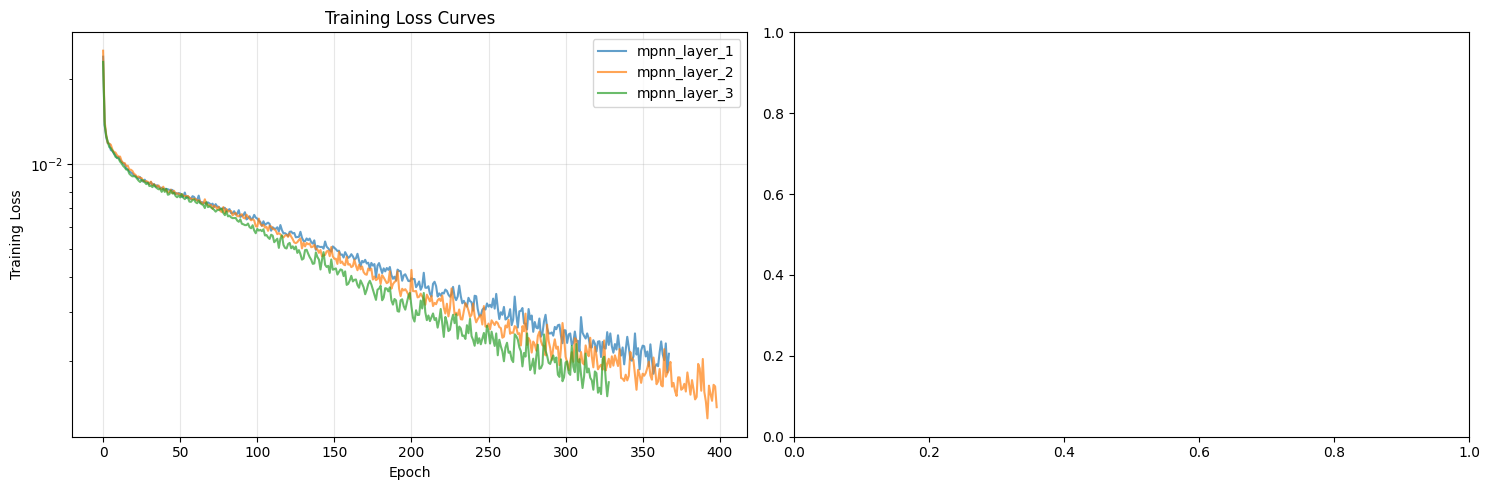

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# --- Only plot successful runs ---
successful_results = [r for r in all_results if 'loss_history' in r]

for result in successful_results:
    # --- Plot 1: Loss curves ---
    axes[0].plot(result['loss_history'], label=result['config_name'], alpha=0.7)
    
    
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Curves')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

<h2> Save Results

In [11]:
import pickle

# --- Create results directory if it doesn't exist ---
results_dir = Path("/results")
#results_dir.mkdir(exist_ok=True)

# --- Generate filename with timestamp ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_file = results_dir / f"hyperparameter_search_{timestamp}.pkl"

# --- Save everything ---
with open(results_file, 'wb') as f:
    pickle.dump({
        'all_results': all_results,
        'configs': configs,
        'results_df': results_df,
        'metadata': {
            'seed': SEED,
            'device': str(device),
            'h5_path': h5_path,
            'test_path': test_path,
        }
    }, f)

print(f"Results saved to: {results_file}")

# --- Also save CSV for spreadsheet analysis ---
csv_file = results_dir / f"hyperparameter_search_{timestamp}.csv"
results_df.to_csv(csv_file, index=False)
print(f"CSV saved to: {csv_file}")

FileNotFoundError: [Errno 2] No such file or directory: '/results/hyperparameter_search_20260212_104606.pkl'